In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('hours_to_project.csv')
df['dt'] =  pd.to_datetime(df['dt'])

In [3]:
df['index'] = df.index

In [4]:
df.head()

,day,project_id,executive_id,hours,dt,index
0,2019-01-09,3016816,6472966665163348977,4,2019-01-11 18:50:19,0
1,2019-01-10,3016816,6472966665163348977,4,2019-01-11 18:50:19,1
2,2019-01-11,3016816,6472966665163348977,4,2019-01-11 18:50:19,2
3,2019-01-14,3016816,6472966665163348977,4,2019-01-11 18:50:24,3
4,2019-01-15,3016816,6472966665163348977,4,2019-01-11 18:50:24,4


### Чистим данные

разбиваем на две группы. с нулевыми и не нулевыми часами

In [5]:
zero_hours = df[df['hours']==0]
df = df[df['hours']!=0]

Делаем группировку и находим накопленную сумму в каждой группе затем фильтруем чтобы в день работы было меньше 8 часов

In [6]:
grouped = df.sort_values(['dt'],ascending=False).groupby(['day', 'executive_id', 'index', 'dt']).first().\
    groupby(level='executive_id').cumsum()

grouped = grouped[grouped['hours']<=8]
grouped

project_id  hours
day        executive_id        index dt                                    
2019-01-07 6171384064617043520 2790  2019-01-22 00:04:01     3016575      4
2019-01-09 4444406782469255273 1320  2018-12-26 15:49:08     3015977      4
           4451437494373826323 1160  2018-12-26 15:17:01     3016987      1
                               1177  2018-12-26 15:17:52     6033817      2
                               1195  2018-12-26 15:21:26     9050221      3
...                                                              ...    ...
2019-11-29 5656997469620366329 39709 2019-11-22 10:00:10     6037030      8
2019-12-02 6761362779808018437 48137 2019-11-28 16:08:25     3017923      4
                               48253 2019-11-28 16:48:37     6036384      8
2019-12-03 6763228741234674346 48519 2019-12-02 19:24:21     3018492      2
                               48523 2019-12-03 13:43:30     6037020      5

[273 rows x 2 columns]

Технические махинации с индексами

In [7]:
grouped['temp_index'] = grouped.index

In [8]:
grouped = grouped.reset_index(drop=True)

In [9]:
grouped['day'] = grouped['temp_index'].apply(lambda x: x[0])
grouped['executive_id'] = grouped['temp_index'].apply(lambda x: x[1])
grouped['index'] = grouped['temp_index'].apply(lambda x: x[2])
grouped['dt'] = grouped['temp_index'].apply(lambda x: x[3])

In [10]:
del grouped['temp_index']

In [11]:
df = grouped

После приведения таблицы к исходноми виду конкатинируем с таблицей с нулевыми часами

In [12]:
df = pd.concat([df, zero_hours]).reset_index(drop=True)

### Поиск не занятых

По данным получили что 20 наименее занятых человек не работали

In [41]:
df[(df['day']>'2019-03-00') & (df['day']<'2019-04-00')].groupby('executive_id')['hours'].sum().sort_values().head(20)

executive_id
4451437494373826323    0
6462283406460924209    0
6465635731514713069    0
6470047208388519868    0
6495725589490647363    0
6497176700026191849    0
6509464781848664412    0
6509466336626809140    0
6532084158393586710    0
6532085790481137245    0
6535323130670474232    0
6548724541030516999    0
6564812595168135526    0
6573593990812262863    0
6574340254264848683    0
6574351902216156546    0
6598153554408635250    0
6616659636479145490    0
6616666010210617868    0
6621860154679826121    0
Name: hours, dtype: int64

Если отбросить не работающих получаем следующий результат

In [40]:
df[(df['day']>'2019-03-00') & (df['day']<'2019-04-00') & (df['hours']>0)].groupby('executive_id')['hours'].sum().sort_values().head(20)

executive_id
6667159870535480136     6
6660000679744052335    12
6665533916176314412    12
6668223824129031472    14
Name: hours, dtype: int64

Распределение замых незанятых сотрудников за март

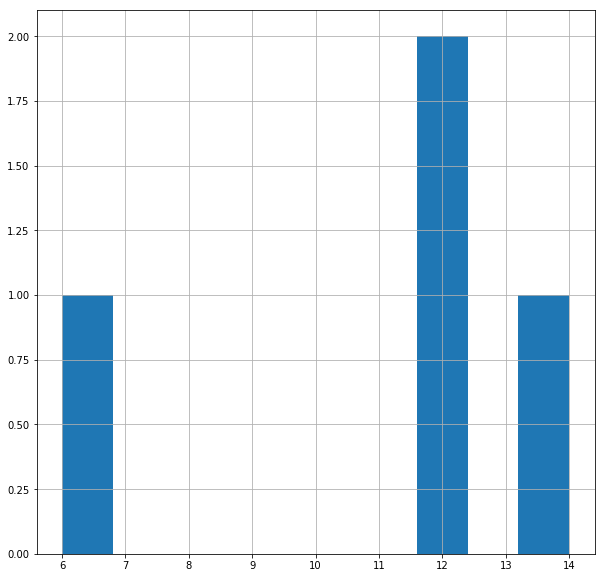

In [42]:
df[(df['day']>'2019-03-00') & (df['day']<'2019-04-00') & (df['hours']>0)].groupby('executive_id')['hours'].sum().sort_values().head(20).hist(figsize=[10,10])

### Распределение длительностей

In [14]:
stage_to_project = pd.read_csv('stage_to_project.csv')

stage_to_project['project_id'] = stage_to_project['project_id'].astype(str)
stage_to_project

,stagedproject_id,project_id
0,3017450,6605850621134324876
1,3017091,6306096057453463865
2,3017941,6715574820660126218
3,3018476,6743777328272336527
4,3017575,6621899346256456096
...,...,...
631,3018843,6724954758683154898
632,3018845,6759504622336998211
633,3019021,6493056095520455161
634,3019085,6772721989053447640


In [15]:
recolumn = {
'project_id':'stagedproject_id'}
df = df.rename(columns=recolumn)

Делаем join с таблицей stage_to_project

In [16]:
joined = df.merge(stage_to_project, how='left', on='stagedproject_id')
joined

,stagedproject_id,hours,day,executive_id,index,dt,project_id
0,3016575,4,2019-01-07,6171384064617043520,2790,2019-01-22 00:04:01,6592653380675954999
1,3015977,4,2019-01-09,4444406782469255273,1320,2018-12-26 15:49:08,6533170450125787926
2,3016987,1,2019-01-09,4451437494373826323,1160,2018-12-26 15:17:01,6205066714275747386
3,6033817,2,2019-01-09,4451437494373826323,1177,2018-12-26 15:17:52,NaN
4,9050221,3,2019-01-09,4451437494373826323,1195,2018-12-26 15:21:26,NaN
...,...,...,...,...,...,...,...
8134,3018636,0,2019-12-25,5625394194018276490,48979,2019-12-23 14:53:48,6751941193518626307
8135,3018023,0,2019-12-25,6592211557348891850,48983,2019-12-20 18:27:53,6724954793090029293
8136,3018588,0,2019-12-21,5142434179669108227,48984,2019-12-20 19:11:06,6750456844231230080
8137,424242421574879261,0,2019-12-22,6673476813945120255,49025,2019-12-23 18:46:28,NaN


Необходимо устранить оставшиеся значения NaN. Для этого разбиваю таблицу на две с Nan и без NaN. затем в той что без Nan заполняю Nan из столбца c id проекта 

In [17]:
joined_not_nan = joined[~(joined['project_id'].isna())]

In [18]:
joined_nan = joined[joined['project_id'].isna()]
joined_nan['project_id']  = joined_nan['stagedproject_id']

c:\users\ilkol\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
joined = pd.concat([joined_not_nan, joined_nan]).reset_index(drop=True)
joined

,stagedproject_id,hours,day,executive_id,index,dt,project_id
0,3016575,4,2019-01-07,6171384064617043520,2790,2019-01-22 00:04:01,6592653380675954999
1,3015977,4,2019-01-09,4444406782469255273,1320,2018-12-26 15:49:08,6533170450125787926
2,3016987,1,2019-01-09,4451437494373826323,1160,2018-12-26 15:17:01,6205066714275747386
3,3016541,3,2019-01-09,4769141486593889576,1814,2018-12-27 20:21:47,6590055775824106125
4,3016665,2,2019-01-09,4782353183953487778,1220,2018-12-26 15:23:43,6600817258768781166
...,...,...,...,...,...,...,...
8134,5852176997052179571,0,2019-12-24,6646314229584445092,48886,2019-12-18 17:10:55,5852176997052179571
8135,5852176997052179571,0,2019-12-26,6646314229584445092,48888,2019-12-18 17:10:55,5852176997052179571
8136,5852176997052179571,0,2019-12-28,6646314229584445092,48904,2019-12-18 17:10:55,5852176997052179571
8137,4444406835586699375,0,2019-12-21,6600962523149708344,48905,2019-12-18 17:11:56,4444406835586699375


Строим гистограмы распределений

Видно что нулевые часы и тут дают о себе знать 

поэтому на втором графике я решил их устранить из рассмотрения

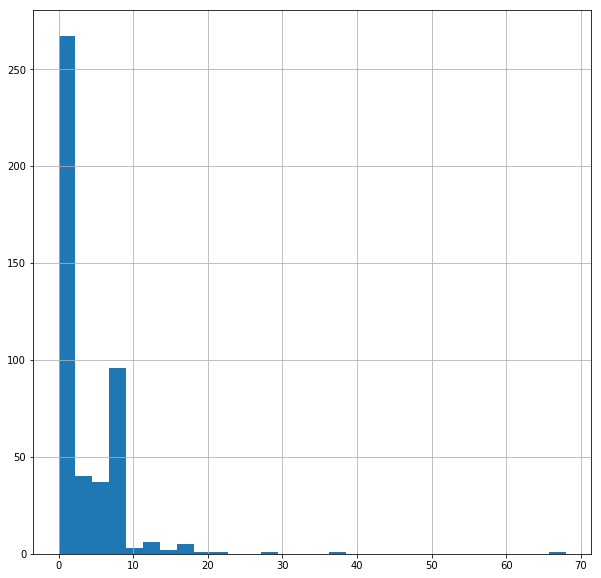

In [21]:
joined.groupby('project_id').hours.sum().hist(bins = 30, figsize=[10,10])

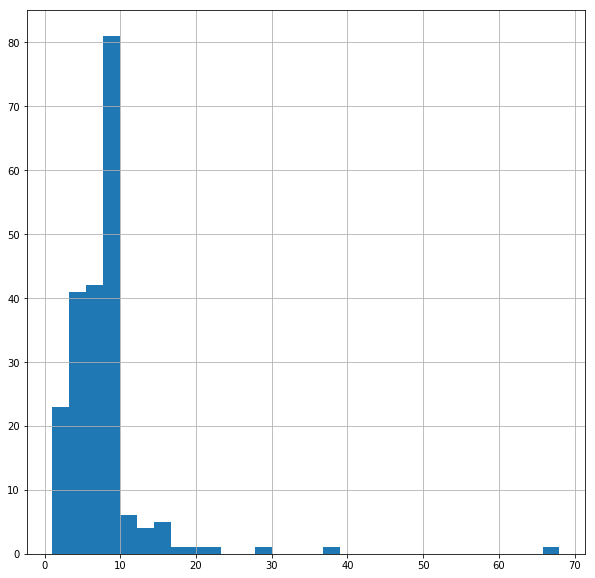

In [22]:
joined[(joined['hours'] != 0)].groupby('project_id').hours.sum().hist(bins = 30, figsize=[10,10])

### Определение недоработки сотрудников до максимума

In [23]:
executive_to_spec = pd.read_csv('executive_to_spec.csv')
executive_to_spec

,executive_id,spec
0,4444406782469255273,технолог
1,4451437494373826323,бета-тестер
2,4638737517754019940,иллюстратор
3,4769141486593889576,дизайнер
4,4782353183953487778,редактор
...,...,...
115,6746482912855683709,архитектор
116,6740908036715540070,дизайнер
117,6749122363532595439,технолог
118,6761362779808018437,дизайнер


Джойним специальность

In [79]:
spec_df = df.merge(executive_to_spec, how='left', on='executive_id')
spec_df['executive_id'] = spec_df['executive_id'].astype(str)
spec_df

,stagedproject_id,hours,day,executive_id,index,dt,spec
0,3016575,4,2019-01-07,6171384064617043520,2790,2019-01-22 00:04:01,дизайнер
1,3015977,4,2019-01-09,4444406782469255273,1320,2018-12-26 15:49:08,технолог
2,3016987,1,2019-01-09,4451437494373826323,1160,2018-12-26 15:17:01,бета-тестер
3,6033817,2,2019-01-09,4451437494373826323,1177,2018-12-26 15:17:52,бета-тестер
4,9050221,3,2019-01-09,4451437494373826323,1195,2018-12-26 15:21:26,бета-тестер
...,...,...,...,...,...,...,...
8134,3018636,0,2019-12-25,5625394194018276490,48979,2019-12-23 14:53:48,верстальщик
8135,3018023,0,2019-12-25,6592211557348891850,48983,2019-12-20 18:27:53,дизайнер
8136,3018588,0,2019-12-21,5142434179669108227,48984,2019-12-20 19:11:06,верстальщик
8137,424242421574879261,0,2019-12-22,6673476813945120255,49025,2019-12-23 18:46:28,дизайнер


In [80]:
spec_df  = spec_df[(spec_df['day']>'2019-00-00') & (spec_df['day']<'2020-00-00')]

Фильтруем по специальности, группируем по сотруднику, сортируем и находим отклонение от максимума. Видно что кому-то долеко до максимума кому-то нет. Можно понять кому и на сколько. У технологов разница от максимума в среднем менее значительна.  

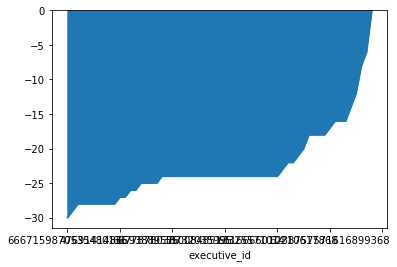

In [88]:
max_ = spec_df[spec_df['spec'] == 'дизайнер'].groupby(['executive_id']).hours.sum().max()
dif = spec_df[spec_df['spec'] == 'дизайнер'].groupby(['executive_id']).hours.sum().sort_values() - max_
dif.plot.area()

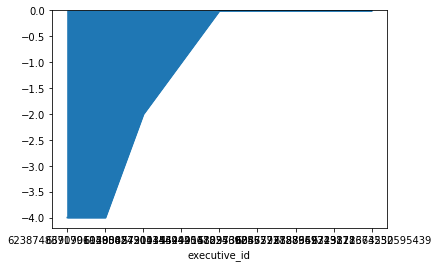

In [87]:
max_ = spec_df[spec_df['spec'] == 'технолог'].groupby(['executive_id']).hours.sum().max()
dif = spec_df[spec_df['spec'] == 'технолог'].groupby(['executive_id']).hours.sum().sort_values() - max_
dif.plot.area()

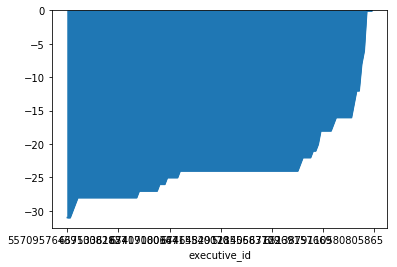

In [90]:
max_ = spec_df.groupby(['executive_id']).hours.sum().max()
dif = spec_df.groupby(['executive_id']).hours.sum().sort_values() - max_
dif.plot.area()